## DRAFT VERSION.

In this notebook, we are trying to reproduce [the paper](http://scuba.usc.edu/pdf/jati2017_Speaker2Vec.pdf).

For review of the paper, you can look [here](https://hedonistrh.github.io/2018-07-09-Literature-Review-for-Speaker-Change-Detection/)

## Feature Extraction

_"We have adopted 40 dimensional high definition MFCC features extracted from 40 mel-spaced filters over a 25ms hamming window with a shift of 10ms using Kaldi toolkit"_ However, I will use [Librosa](https://librosa.github.io).



## Prepare Data

_"We have used d = 100 frames (1s) for all training scenarios. This makes the size of input and output layers of the DNN models to be 4000."_

_"40 mel-spaced filters over a 25ms hamming window with a shift of 10ms"_

In [ ]:
!mkdir audio_files # this folder store audio_files

We will use some data from Youtube. To download these files, [youtube-dl](https://rg3.github.io/youtube-dl/index.html) is used.

In [ ]:
# https://askubuntu.com/questions/564567/how-to-download-playlist-from-youtube-dl
# https://www.slashgeek.net/2016/06/24/5-youtube-dl-tips-might-not-know/
!youtube-dl --extract-audio --audio-format m4a -o "./audio_files/%(title)s.%(ext)s" https://www.youtube.com/playlist?list=

In [7]:
!pwd

/home/herdogan/Desktop/SpChangeDetect


In [8]:
import librosa
import os
import glob
import numpy as np
import sys

def wav_to_matrix(filename, hop, win_len): # hop and win_len in milisecond 
    audio, sr = librosa.load(filename)
    # https://github.com/librosa/librosa/issues/584
    mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=40, hop_length=int(float(hop/1000)*sr), n_fft=int(float(win_len/1000)*sr))
    # line_mfccs = np.ravel(mfccs, order='F')
    return mfccs

def create_data_for_unsupervised(root_dir, hop, win_len):
    all_wav_paths = glob.glob(os.path.join(root_dir, '*m4a'))
    matrix_of_all_wav = []
    print (all_wav_paths)

    # All midi have to be in same shape. (?)
    for single_wav_path in all_wav_paths:
        print (single_wav_path)
        matrix_of_single_wav = wav_to_matrix(single_wav_path, hop, win_len)
        array_of_single_wav = np.ravel(matrix_of_single_wav)
        
        if (matrix_of_single_wav is not None):
            print (matrix_of_single_wav.shape)
            matrix_of_all_wav.extend(array_of_single_wav)
            print (single_wav_path + " is done.")
            
    wav_array = np.asarray(matrix_of_all_wav)
    wav_array = np.reshape(matrix_of_all_wav, (40,-1))
    input_array = []
    output_array = []

    print (wav_array.shape)
    
    start_point = 0
    
    while (start_point+200 < wav_array.shape[1]):
        single_input = wav_array[0:40,start_point:start_point+100]
        single_output = wav_array[:40, start_point+100:start_point+200]
        input_array.append(single_input)
        output_array.append(single_output)
        start_point += 100
        
        
    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))  
    print(input_array.shape)

    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array), np.prod(output_array.shape[1:])))  
    print(output_array.shape)
    
    return (input_array, output_array)

In [9]:
input_array, output_array = create_data_for_unsupervised('./audio_files/', 10, 25)

[]
(40, 0)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [10]:
import librosa
import os
import glob
import numpy as np
import sys

def upload_npy_to_arrays(root_dir, from_ep = 0, to_ep=0):
    all_npy_paths = glob.glob(os.path.join(root_dir, '*npy'))
    matrix_of_all_wav = []

    num = 0
    for single_npy_path in all_npy_paths:
        num += 1
        if (num >= from_ep):
            array_of_single_wav = np.load(single_npy_path)
            
            if (num > to_ep):
                break
                    
            else:
                if (array_of_single_wav is not None):
                     matrix_of_all_wav.extend(array_of_single_wav)
            
    wav_array = np.asarray(matrix_of_all_wav)
    wav_array = np.reshape(matrix_of_all_wav, (40,-1))
    input_array = []
    output_array = []

    print (wav_array.shape)
    
    start_point = 0
    
    while (start_point+200 < wav_array.shape[1]):
        single_input = wav_array[0:40,start_point:start_point+100]
        single_output = wav_array[:40, start_point+100:start_point+200]
        input_array.append(single_input)
        output_array.append(single_output)
        start_point += 100
        
        
    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))  
    print(input_array.shape)

    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array), np.prod(output_array.shape[1:])))  
    print(output_array.shape)
    
    return (input_array, output_array)

In [11]:
input_array, output_array = upload_npy_to_arrays('./npy_files/', 0, 1)

(40, 453631)
(4535, 4000)
(4535, 4000)


**Let's focus on AMI Corpus**

In the [dev.mdtm](https://github.com/pyannote/pyannote-db-odessa-ami/tree/master/AMI/data/speaker_diarization), we can see the:
    - filename, offset, duration, "speaker NA unknown", id of speaker

We should focus on this. We can download the corresponding .wav files easily. 

Firsly, I will create database for speaker change detection. It will be not-optimized until the end of test.

In [ ]:
# !ls

In [12]:
mkdir txt_files

In [13]:
import sys
import numpy as np

def create_ground_truth(main_set):
    # start_time_array = []
    end_time_array = []
    output_frame_array = []
    with open(main_set) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    tmp_filename = content[0].split(' ')[0]
    # sys.exit("WAIT, TEST :)")

    for single_line in content:
        filename = single_line.split(' ')[0]
        # print (filename)
        if (filename != tmp_filename):
            # start_time_array = np.asarray(start_time_array)
            # np.savetxt(fname=tmp_filename + "_start_time.txt", X=start_time_array, delimiter=' ', fmt='%1.3f')
            # end_time_array = np.asarray(end_time_array)
            np.savetxt(fname=tmp_filename + "_end_time.txt", X=end_time_array, delimiter=' ', fmt='%1.3f')
            # start_time_array = []
            end_time_array = []
            
        tmp_filename = single_line.split(' ')[0]
        offset = float(single_line.split(' ')[2])
        duration = float(single_line.split(' ')[3])
        end_time = offset+duration
        # start_time_array.append(offset)
        end_time_array.append(end_time)

In [14]:
cd txt_files

/home/herdogan/Desktop/SpChangeDetect/txt_files


In [15]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/dev.mdtm

--2018-08-01 17:24:22--  https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/dev.mdtm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580919 (567K) [text/plain]
Saving to: ‘dev.mdtm’

dev.mdtm            100%[===================>] 567,30K  --.-KB/s    in 0,04s   

2018-08-01 17:24:23 (15,6 MB/s) - ‘dev.mdtm’ saved [580919/580919]



In [16]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/tst.mdtm

--2018-08-01 17:24:23--  https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/tst.mdtm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604216 (590K) [text/plain]
Saving to: ‘tst.mdtm’

tst.mdtm            100%[===================>] 590,05K  --.-KB/s    in 0,05s   

2018-08-01 17:24:23 (11,7 MB/s) - ‘tst.mdtm’ saved [604216/604216]



In [17]:
!wget https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/trn.mdtm

--2018-08-01 17:24:23--  https://raw.githubusercontent.com/pyannote/pyannote-db-odessa-ami/master/AMI/data/speaker_diarization/trn.mdtm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3214846 (3,1M) [text/plain]
Saving to: ‘trn.mdtm’

trn.mdtm            100%[===================>]   3,07M  --.-KB/s    in 0,1s    

2018-08-01 17:24:24 (23,8 MB/s) - ‘trn.mdtm’ saved [3214846/3214846]



In [18]:
create_ground_truth('dev.mdtm')

In [19]:
create_ground_truth('trn.mdtm')

In [20]:
create_ground_truth('tst.mdtm')

In [21]:
cd ..

/home/herdogan/Desktop/SpChangeDetect


## Deep Learning Architectures

- They use 2 different autoencoder. 
    - Smaller is 4000 → 2000 → 40 → 2000 → 4000
    - Larger is 4000 → 6000 → 2000 → 40 → 2000 → 6000 → 4000
![Image of Autoencoder](https://docs.google.com/uc?id=1epse9ba1fRTdmyN3pF0XoECEHcaiLsa3)


In [26]:
from keras import layers
from keras import models
from keras import optimizers
import keras
from keras.models import Model
import tensorflow as tf
from keras.layers.advanced_activations import *


input_frame = keras.Input(shape=(4000,), name='main_input')
encoded_1 = layers.Dense(4000, activation='relu', name='encoded_1')(input_frame) # not quite sure about the activation
encoded_2 = layers.Dense(2000, activation='relu', name='encoded_2')(encoded_1)

embedding = layers.Dense(40, activation='relu', name='embedding')(encoded_2)

decoded_1 = layers.Dense(2000, activation='relu', name='decoded_1')(embedding)
decoded_2 = layers.Dense(4000, activation='linear', name='decoded_2')(decoded_1)

autoencoder = Model(input_frame, decoded_2)

rmsprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
autoencoder.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 4000)              0         
_________________________________________________________________
encoded_1 (Dense)            (None, 4000)              16004000  
_________________________________________________________________
encoded_2 (Dense)            (None, 2000)              8002000   
_________________________________________________________________
embedding (Dense)            (None, 40)                80040     
_________________________________________________________________
decoded_1 (Dense)            (None, 2000)              82000     
_________________________________________________________________
decoded_2 (Dense)            (None, 4000)              8004000   
Total params: 32,172,040
Trainable params: 32,172,040
Non-trainable params: 0
________________________________________________________________

In [27]:
from keras.models import load_model


how_many_step = 25
ix_step = 0
from_epi = 0

while (ix_step < how_many_step):
    ix_step += 1
    
    input_array, output_array = upload_npy_to_arrays('./npy_files/', from_ep=from_epi, to_ep=from_epi+4)
    
    try:
        autoencoder.fit(input_array, output_array,
               epochs=2,
               batch_size=16,
               shuffle=True)
        autoencoder.save_weights('speaker2vec_weights.h5')    

    except:
        print ("pass this epoch")
        pass
    
    # https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

    
    input_array = []
    output_array = []
    
    from_epi += 4

(40, 1895177)
(18950, 4000)
(18950, 4000)
Epoch 1/2
18950/18950 [==============================] - 412s 22ms/step - loss: 2.2619
Epoch 2/2
18950/18950 [==============================] - 405s 21ms/step - loss: 2.2503
(40, 2125596)
(21254, 4000)
(21254, 4000)
Epoch 1/2
21254/21254 [==============================] - 461s 22ms/step - loss: 2.4512
Epoch 2/2
21254/21254 [==============================] - 461s 22ms/step - loss: 2.4508
(40, 2212710)
(22126, 4000)
(22126, 4000)
Epoch 1/2
22126/22126 [==============================] - 485s 22ms/step - loss: 2.2482
Epoch 2/2
22126/22126 [==============================] - 478s 22ms/step - loss: 2.2476
(40, 2233608)
(22335, 4000)
(22335, 4000)
Epoch 1/2
22335/22335 [==============================] - 491s 22ms/step - loss: 2.0648
Epoch 2/2
22335/22335 [==============================] - 481s 22ms/step - loss: 2.0648
(40, 2605471)
(26053, 4000)
(26053, 4000)
Epoch 1/2
26053/26053 [==============================] - 571s 22ms/step - loss: 1.9285
Epoch 2

**Let's try to detect speaker change points. We will use encoder part of autoencoder.**
- Firstly, extract the embedding,
- Compare neighboorhood embeddings via different parameters,
- If result of comparision exceed determined threshold, it represent the speaker change point.

In [28]:
embedding_system = Model(input_frame, embedding) # create system to extraxt embed.

Now, we have embedding system. We should feed this sytem via input frames.

In [29]:
from scipy.signal import savgol_filter
import scipy 

def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.00001

     # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.sum(P*np.log(P/Q))
    return divergence

def create_prediction(wav_file, hop, win_len, threshold, embedding_system):
    KL_array = []
    prediction_array = []
    audio, sr = librosa.load(wav_file)
    # at that point, we should not use overlapping segment
    # https://github.com/librosa/librosa/issues/584
    mfccs = librosa.feature.mfcc(audio, sr, n_mfcc=40, hop_length=int(hop/1000*sr), n_fft=int(win_len/1000*sr))
    # now we have mfcc of all audio file.
    offset=0
    while (offset+200 < mfccs.shape[1]):
    # line_mfccs = np.ravel(mfccs, order='F')
        first_frame = np.ravel(mfccs[0:40,offset:offset+100])
        first_frame = np.expand_dims(first_frame, axis=0)
        first_embed = embedding_system.predict(first_frame)
        
        second_frame = np.ravel(mfccs[0:40,offset+100:offset+200])
        second_frame = np.expand_dims(second_frame, axis=0)
        second_embed = embedding_system.predict(second_frame)
        KL_array.append(KL(first_embed, second_embed))
        offset += 100
    KL_array = np.asarray(KL_array)
        
    # min max normalization
    KL_array_to_0_1 = (KL_array-min(KL_array))/(max(KL_array)-min(KL_array))
    KL_array_to_0_1 = np.asarray(KL_array_to_0_1)
    # print (KL_array_to_0_1)    
    
    # Now, we should apply lowpass filter to get smooth KL curve.
    # https://stats.stackexchange.com/questions/323069/can-kl-divergence-ever-be-greater-than-1
    # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
    KL_array_smooth = savgol_filter(KL_array_to_0_1, 51, 3)
    KL_array_smooth = np.asarray(KL_array_smooth)    
        
    offset = 0
    
    for KL_value in KL_array_smooth:
        if (KL_value > threshold):
            ms_version = float(win_len + ((offset+100) * hop)) # milisecond version to represent end point of first embed            
            prediction_array.append(ms_version/1000)
            
        offset += 100
            
    prediction_array = np.asarray(prediction_array)
    np.savetxt(fname=wav_file.split("/")[-1] + "_prediction.txt", X=prediction_array, 
               delimiter=' ', fmt='%1.3f')

    return (prediction_array, KL_array_to_0_1, KL_array_smooth)

**Now, implement transfer learning part. We will do it because of unsupervised domain adaptation.**
- Find the speaker change points by trained DNN,
- Get all possible speaker homogeneous regions,
- Retrain the same DNN again on these homogeneous segments of speech.

In [30]:
change_points, arr, arr_s = create_prediction('./audio_files_full/Kafa Ayarı #5 - Hızlı Trenler ile Saatte 8000 Kilometre!.mp3', hop=10, win_len=25, threshold=0.21, embedding_system=embedding_system)

/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [31]:
import matplotlib.pyplot as pp

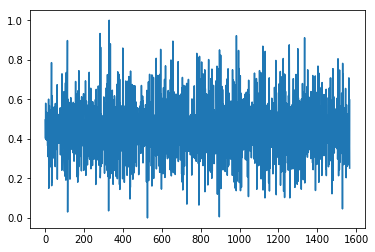

In [32]:
pp.plot(arr)
pp.show()

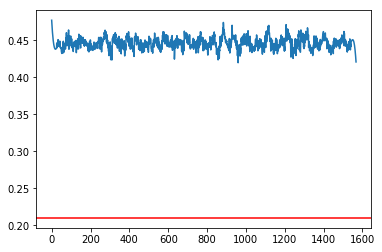

In [33]:
pp.plot(arr_s)
pp.axhline(y=0.21, color='r', linestyle='-')
pp.show()

In [34]:
arr_s

array([0.4773948 , 0.47287625, 0.46869117, ..., 0.4283904 , 0.42485318,
       0.42099875], dtype=float32)

In [ ]:
change_points = create_prediction('test.wav', hop=10, win_len=25, threshold=0.6, embedding_system=embedding_system)

# This is for unsupervised adaptation.

## Very bad according to optimization view. !!!
def creata_data_for_unsuper_adaptation(root_dir, hop, win_len):
    all_wav_paths = glob.glob(os.path.join(root_dir, '*m4a'))
    matrix_of_all_wav = []
    
    input_array = []
    output_array = []
    
    for single_wav_path in all_wav_paths:
        prediction_array = create_prediction(wav_file, hop, win_len, threshold, embedding_system)
        matrix_of_single_wav = wav_to_matrix(single_wav_path, hop, win_len)
            
        start_point = 0
        while (start_point+200 < matrix_of_single_wav.shape[1]):
            change = 0 # value to check any value in prediction array is in range of frame
            for single_change in prediction_array:
                if (single_change in range(float(win_len + ((offset) * hop)), 
                                               float(win_len + ((offset+200) * hop)))):
                    change = 1
            if (change == 0):
                single_input = wav_array[0:40,start_point:start_point+100]
                single_output = wav_array[:40, start_point+100:start_point+200]
                input_array.append(single_input)
                output_array.append(single_output)
            start_point += 100

    input_array = np.asarray(input_array)
    input_array = input_array.reshape((len(input_array), np.prod(input_array.shape[1:])))
    
    output_array = np.asarray(output_array)
    output_array = output_array.reshape((len(output_array)*output_array.shape[1], output_array.shape[2]*output_array.shape[3] ))

    print(output_array.shape)
    
    return (input_array, output_array)
